# Exploring US Code Structure from OLRC

This notebook explores the structure of the United States Code as provided by the Office of the Law Revision Counsel (OLRC).

## Goals
1. Understand the hierarchical structure: Titles → Chapters → Sections → Subsections
2. Explore OLRC's XML format and data availability
3. Parse and visualize code structure
4. Experiment with line-level parsing for the CWLB "blame view" feature

## US Code Structure Overview

```
Title (e.g., Title 17 - Copyright)
├── Chapter (e.g., Chapter 1 - Subject Matter and Scope)
│   ├── Section (e.g., § 106 - Exclusive rights)
│   │   ├── Subsection (e.g., (1), (2), (a), (b))
│   │   │   ├── Paragraph (e.g., (A), (B))
│   │   │   │   └── Clause (e.g., (i), (ii))
```

In [ ]:
# Import required libraries
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import json
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')

print("✓ Libraries imported successfully")

Matplotlib is building the font cache; this may take a moment.


✓ Libraries imported successfully


## 1. Accessing OLRC Data

The Office of the Law Revision Counsel provides US Code data in XML format at https://uscode.house.gov/

### Available Resources:
- **XML Downloads**: Full titles in structured XML format
- **Download Service**: https://uscode.house.gov/download/download.shtml
- **Release Points**: Periodic official releases with complete XML data

In [ ]:
# OLRC Download Information
OLRC_BASE_URL = "https://uscode.house.gov"
OLRC_DOWNLOAD_URL = f"{OLRC_BASE_URL}/download/download.shtml"

print(f"OLRC Main Site: {OLRC_BASE_URL}")
print(f"Download Page: {OLRC_DOWNLOAD_URL}")
print("\nNote: You'll need to download XML files from the OLRC website.")
print("This notebook will demonstrate parsing with example XML data.")

OLRC Main Site: https://uscode.house.gov
Download Page: https://uscode.house.gov/download/download.shtml

Note: You'll need to download XML files from the OLRC website.
This notebook will demonstrate parsing with example XML data.


## 2. Example XML Structure

Let's create an example XML snippet based on OLRC's format to demonstrate parsing.
This follows the structure of actual OLRC XML files.

In [ ]:
# Example XML structure based on OLRC format (simplified version of Title 17, Section 106)
example_xml = '''<?xml version="1.0" encoding="UTF-8"?>
<title number="17">
  <heading>COPYRIGHTS</heading>
  <chapter number="1">
    <heading>Subject Matter and Scope of Copyright</heading>
    <section number="106">
      <heading>Exclusive rights in copyrighted works</heading>
      <content>
        <para>
          <text>Subject to sections 107 through 122, the owner of copyright under this title has the exclusive rights to do and to authorize any of the following:</text>
        </para>
        <enum>
          <item number="1">
            <text>to reproduce the copyrighted work in copies or phonorecords;</text>
          </item>
          <item number="2">
            <text>to prepare derivative works based upon the copyrighted work;</text>
          </item>
          <item number="3">
            <text>to distribute copies or phonorecords of the copyrighted work to the public by sale or other transfer of ownership, or by rental, lease, or lending;</text>
          </item>
          <item number="4">
            <text>in the case of literary, musical, dramatic, and choreographic works, pantomimes, and motion pictures and other audiovisual works, to perform the copyrighted work publicly;</text>
          </item>
          <item number="5">
            <text>in the case of literary, musical, dramatic, and choreographic works, pantomimes, and pictorial, graphic, or sculptural works, including the individual images of a motion picture or other audiovisual work, to display the copyrighted work publicly; and</text>
          </item>
          <item number="6">
            <text>in the case of sound recordings, to perform the copyrighted work publicly by means of a digital audio transmission.</text>
          </item>
        </enum>
      </content>
    </section>
    <section number="107">
      <heading>Limitations on exclusive rights: Fair use</heading>
      <content>
        <para>
          <text>Notwithstanding the provisions of sections 106 and 106A, the fair use of a copyrighted work, including such use by reproduction in copies or phonorecords or by any other means specified by that section, for purposes such as criticism, comment, news reporting, teaching (including multiple copies for classroom use), scholarship, or research, is not an infringement of copyright.</text>
        </para>
      </content>
    </section>
  </chapter>
</title>
'''

print("Example XML loaded (simplified Title 17, Chapter 1)")
print(f"Length: {len(example_xml)} characters")

Example XML loaded (simplified Title 17, Chapter 1)
Length: 2377 characters


## 3. Parsing the XML Structure

In [ ]:
# Parse the XML
root = etree.fromstring(example_xml.encode('utf-8'))

# Extract title information
title_number = root.get('number')
title_heading = root.find('heading').text

print(f"Title {title_number}: {title_heading}")
print("="*60)

# Extract chapter and section information
sections_data = []

for chapter in root.findall('.//chapter'):
    chapter_number = chapter.get('number')
    chapter_heading = chapter.find('heading').text if chapter.find('heading') is not None else 'N/A'
    
    print(f"\nChapter {chapter_number}: {chapter_heading}")
    print("-"*60)
    
    for section in chapter.findall('.//section'):
        section_number = section.get('number')
        section_heading = section.find('heading').text if section.find('heading') is not None else 'N/A'
        
        # Count elements
        paragraphs = len(section.findall('.//para'))
        items = len(section.findall('.//item'))
        
        sections_data.append({
            'title': title_number,
            'chapter': chapter_number,
            'section': section_number,
            'heading': section_heading,
            'paragraphs': paragraphs,
            'items': items
        })
        
        print(f"  § {section_number}: {section_heading}")
        print(f"    Paragraphs: {paragraphs}, Enumerated items: {items}")

# Create DataFrame
df_sections = pd.DataFrame(sections_data)
print("\n" + "="*60)
print("Summary DataFrame:")
df_sections

Title 17: COPYRIGHTS

Chapter 1: Subject Matter and Scope of Copyright
------------------------------------------------------------
  § 106: Exclusive rights in copyrighted works
    Paragraphs: 1, Enumerated items: 6
  § 107: Limitations on exclusive rights: Fair use
    Paragraphs: 1, Enumerated items: 0

Summary DataFrame:


,title,chapter,section,heading,paragraphs,items
0,17,1,106,Exclusive rights in copyrighted works,1,6
1,17,1,107,Limitations on exclusive rights: Fair use,1,0


## 4. Deep Dive: Parsing Section 106 Line by Line

For the CWLB "blame view" feature, we need to parse sections into individual lines with parent/child relationships.
Let's explore how to build this tree structure.

In [ ]:
class USCodeLine:
    """Represents a single line in the US Code with tree structure"""
    def __init__(self, line_id, line_number, line_type, text_content, 
                 subsection_path=None, parent_line_id=None, depth_level=0):
        self.line_id = line_id
        self.line_number = line_number
        self.line_type = line_type  # Heading, Prose, ListItem
        self.text_content = text_content
        self.subsection_path = subsection_path
        self.parent_line_id = parent_line_id
        self.depth_level = depth_level
        self.children = []
    
    def add_child(self, child):
        self.children.append(child)
    
    def __repr__(self):
        indent = "  " * self.depth_level
        path = f" [{self.subsection_path}]" if self.subsection_path else ""
        text_preview = self.text_content[:50] + "..." if len(self.text_content) > 50 else self.text_content
        return f"{indent}{self.line_type}{path}: {text_preview}"

def parse_section_lines(section_element):
    """Parse a section into USCodeLine objects with tree structure"""
    lines = []
    line_id_counter = 1
    line_number = 1
    
    section_number = section_element.get('number')
    section_heading = section_element.find('heading').text if section_element.find('heading') is not None else ''
    
    # Line 1: Section heading
    heading_line = USCodeLine(
        line_id=line_id_counter,
        line_number=line_number,
        line_type='Heading',
        text_content=f"§ {section_number}. {section_heading}",
        depth_level=0
    )
    lines.append(heading_line)
    current_parent = heading_line
    line_id_counter += 1
    line_number += 1
    
    # Parse content
    content = section_element.find('content')
    if content is not None:
        for element in content:
            if element.tag == 'para':
                text_elem = element.find('text')
                if text_elem is not None and text_elem.text:
                    prose_line = USCodeLine(
                        line_id=line_id_counter,
                        line_number=line_number,
                        line_type='Prose',
                        text_content=text_elem.text,
                        parent_line_id=heading_line.line_id,
                        depth_level=1
                    )
                    lines.append(prose_line)
                    heading_line.add_child(prose_line)
                    current_parent = prose_line
                    line_id_counter += 1
                    line_number += 1
            
            elif element.tag == 'enum':
                for item in element.findall('item'):
                    item_number = item.get('number')
                    text_elem = item.find('text')
                    if text_elem is not None and text_elem.text:
                        list_line = USCodeLine(
                            line_id=line_id_counter,
                            line_number=line_number,
                            line_type='ListItem',
                            text_content=text_elem.text,
                            subsection_path=f"({item_number})",
                            parent_line_id=current_parent.line_id,
                            depth_level=current_parent.depth_level + 1
                        )
                        lines.append(list_line)
                        current_parent.add_child(list_line)
                        line_id_counter += 1
                        line_number += 1
    
    return lines

# Parse section 106
section_106 = root.find('.//section[@number="106"]')
lines_106 = parse_section_lines(section_106)

print("Section 106 parsed into lines:")
print("="*60)
for line in lines_106:
    print(line)

Section 106 parsed into lines:
Heading: § 106. Exclusive rights in copyrighted works
  Prose: Subject to sections 107 through 122, the owner of ...
    ListItem [(1)]: to reproduce the copyrighted work in copies or pho...
    ListItem [(2)]: to prepare derivative works based upon the copyrig...
    ListItem [(3)]: to distribute copies or phonorecords of the copyri...
    ListItem [(4)]: in the case of literary, musical, dramatic, and ch...
    ListItem [(5)]: in the case of literary, musical, dramatic, and ch...
    ListItem [(6)]: in the case of sound recordings, to perform the co...


## 5. Visualizing the Tree Structure

In [ ]:
# Create a visual representation of the tree
def print_tree(line, prefix="", is_last=True):
    """Recursively print the tree structure"""
    connector = "└── " if is_last else "├── "
    path = f" [{line.subsection_path}]" if line.subsection_path else ""
    text_preview = line.text_content[:60] + "..." if len(line.text_content) > 60 else line.text_content
    print(f"{prefix}{connector}{line.line_type}{path}: {text_preview}")
    
    extension = "    " if is_last else "│   "
    for i, child in enumerate(line.children):
        print_tree(child, prefix + extension, i == len(line.children) - 1)

print("Tree Structure Visualization:")
print("="*60)
print_tree(lines_106[0])

Tree Structure Visualization:
└── Heading: § 106. Exclusive rights in copyrighted works
    └── Prose: Subject to sections 107 through 122, the owner of copyright ...
        ├── ListItem [(1)]: to reproduce the copyrighted work in copies or phonorecords;
        ├── ListItem [(2)]: to prepare derivative works based upon the copyrighted work;
        ├── ListItem [(3)]: to distribute copies or phonorecords of the copyrighted work...
        ├── ListItem [(4)]: in the case of literary, musical, dramatic, and choreographi...
        ├── ListItem [(5)]: in the case of literary, musical, dramatic, and choreographi...
        └── ListItem [(6)]: in the case of sound recordings, to perform the copyrighted ...


## 6. Line-Level Data Structure for Database

This demonstrates how the parsed lines would be stored in the database for the CWLB platform.

In [ ]:
# Convert to tabular format for database storage
def lines_to_dataframe(lines):
    """Convert USCodeLine objects to DataFrame"""
    data = []
    for line in lines:
        data.append({
            'line_id': line.line_id,
            'line_number': line.line_number,
            'line_type': line.line_type,
            'subsection_path': line.subsection_path,
            'parent_line_id': line.parent_line_id,
            'depth_level': line.depth_level,
            'text_content': line.text_content[:60] + '...' if len(line.text_content) > 60 else line.text_content
        })
    return pd.DataFrame(data)

df_lines = lines_to_dataframe(lines_106)
print("Line-Level Database Structure:")
print("="*60)
df_lines

Line-Level Database Structure:


,line_id,line_number,line_type,subsection_path,parent_line_id,depth_level,text_content
0,1,1,Heading,NaN,NaN,0,§ 106. Exclusive rights in copyrighted works
1,2,2,Prose,NaN,1.0,1,"Subject to sections 107 through 122, the owner of copyright ..."
2,3,3,ListItem,(1),2.0,2,to reproduce the copyrighted work in copies or phonorecords;
3,4,4,ListItem,(2),2.0,2,to prepare derivative works based upon the copyrighted work;
4,5,5,ListItem,(3),2.0,2,to distribute copies or phonorecords of the copyrighted work...
5,6,6,ListItem,(4),2.0,2,"in the case of literary, musical, dramatic, and choreographi..."
6,7,7,ListItem,(5),2.0,2,"in the case of literary, musical, dramatic, and choreographi..."
7,8,8,ListItem,(6),2.0,2,"in the case of sound recordings, to perform the copyrighted ..."


## 7. Simulating the "Blame View"

In CWLB, each line will be attributed to the Public Law that created or last modified it.
Let's simulate what this would look like.

In [ ]:
# Simulate blame information (would come from actual Public Law data)
import random

# Example laws that might have modified Title 17
example_laws = [
    {'law_number': 'PL 94-553', 'congress': 94, 'president': 'Ford', 'year': 1976, 'name': 'Copyright Act of 1976'},
    {'law_number': 'PL 101-650', 'congress': 101, 'president': 'Bush', 'year': 1990, 'name': 'Visual Artists Rights Act'},
    {'law_number': 'PL 105-304', 'congress': 105, 'president': 'Clinton', 'year': 1998, 'name': 'Digital Millennium Copyright Act'},
]

# Assign blame to each line (simulated)
def add_blame_info(df_lines, laws):
    df_blame = df_lines.copy()
    
    # Simulate: original lines from PL 94-553, some modified by later laws
    df_blame['law_number'] = 'PL 94-553'
    df_blame['congress'] = '94th'
    df_blame['president'] = 'Ford'
    df_blame['year'] = 1976
    
    # Simulate line 5 (item 3) modified by later law
    if len(df_blame) > 4:
        df_blame.loc[4, 'law_number'] = 'PL 101-650'
        df_blame.loc[4, 'congress'] = '101st'
        df_blame.loc[4, 'president'] = 'Bush'
        df_blame.loc[4, 'year'] = 1990
    
    return df_blame

df_with_blame = add_blame_info(df_lines, example_laws)

print("Blame View - Each line attributed to a Public Law:")
print("="*60)
df_with_blame[['line_number', 'line_type', 'subsection_path', 'law_number', 'congress', 'president', 'year', 'text_content']]

Blame View - Each line attributed to a Public Law:


,line_number,line_type,subsection_path,law_number,congress,president,year,text_content
0,1,Heading,NaN,PL 94-553,94th,Ford,1976,§ 106. Exclusive rights in copyrighted works
1,2,Prose,NaN,PL 94-553,94th,Ford,1976,"Subject to sections 107 through 122, the owner of copyright ..."
2,3,ListItem,(1),PL 94-553,94th,Ford,1976,to reproduce the copyrighted work in copies or phonorecords;
3,4,ListItem,(2),PL 94-553,94th,Ford,1976,to prepare derivative works based upon the copyrighted work;
4,5,ListItem,(3),PL 101-650,101st,Bush,1990,to distribute copies or phonorecords of the copyrighted work...
5,6,ListItem,(4),PL 94-553,94th,Ford,1976,"in the case of literary, musical, dramatic, and choreographi..."
6,7,ListItem,(5),PL 94-553,94th,Ford,1976,"in the case of literary, musical, dramatic, and choreographi..."
7,8,ListItem,(6),PL 94-553,94th,Ford,1976,"in the case of sound recordings, to perform the copyrighted ..."


## 8. Blame View Visualization

This is how the blame view would appear in the CWLB interface.

In [ ]:
# Create a visual blame view
def print_blame_view(df_blame):
    print("┌" + "─"*80 + "┐")
    print("│ § 106 · Exclusive rights in copyrighted works" + " "*34 + "│")
    print("│" + " "*80 + "│")
    
    for _, row in df_blame.iterrows():
        if row['line_type'] == 'Heading':
            continue  # Skip heading for this view
        
        # Format blame info
        blame = f"{row['law_number']:12} {row['congress']:8} {row['president']:8} {row['year']}"
        
        # Format text with indentation
        indent = "  " * (row['depth_level'] - 1)
        path = f"{row['subsection_path']} " if pd.notna(row['subsection_path']) else ""
        text = row['text_content']
        
        # Word wrap for display
        max_text_width = 80 - len(blame) - len(indent) - len(path) - 5
        if len(text) > max_text_width:
            text = text[:max_text_width-3] + "..."
        
        line = f"│ {blame} │ {indent}{path}{text}"
        padding = 80 - len(line) + 1
        print(line + " "*padding + "│")
    
    print("└" + "─"*80 + "┘")
    print("\n       ↑")
    print("  Click any line to see full law details")

print("\nBlame View Visualization:")
print("="*82)
print_blame_view(df_with_blame)


Blame View Visualization:
┌────────────────────────────────────────────────────────────────────────────────┐
│ § 106 · Exclusive rights in copyrighted works                                  │
│                                                                                │
│ PL 94-553    94th     Ford     1976 │ Subject to sections 107 through 122, ... │
│ PL 94-553    94th     Ford     1976 │   (1) to reproduce the copyrighted wo... │
│ PL 94-553    94th     Ford     1976 │   (2) to prepare derivative works bas... │
│ PL 101-650   101st    Bush     1990 │   (3) to distribute copies or phonore... │
│ PL 94-553    94th     Ford     1976 │   (4) in the case of literary, musica... │
│ PL 94-553    94th     Ford     1976 │   (5) in the case of literary, musica... │
│ PL 94-553    94th     Ford     1976 │   (6) in the case of sound recordings... │
└────────────────────────────────────────────────────────────────────────────────┘

       ↑
  Click any line to see full law details


## 9. Structure Analysis Across Multiple Sections

Section Structure Statistics:
  section  total_lines  heading_lines  prose_lines  list_items  max_depth
0     106            8              1            1           6          2
1     107            2              1            1           0          1


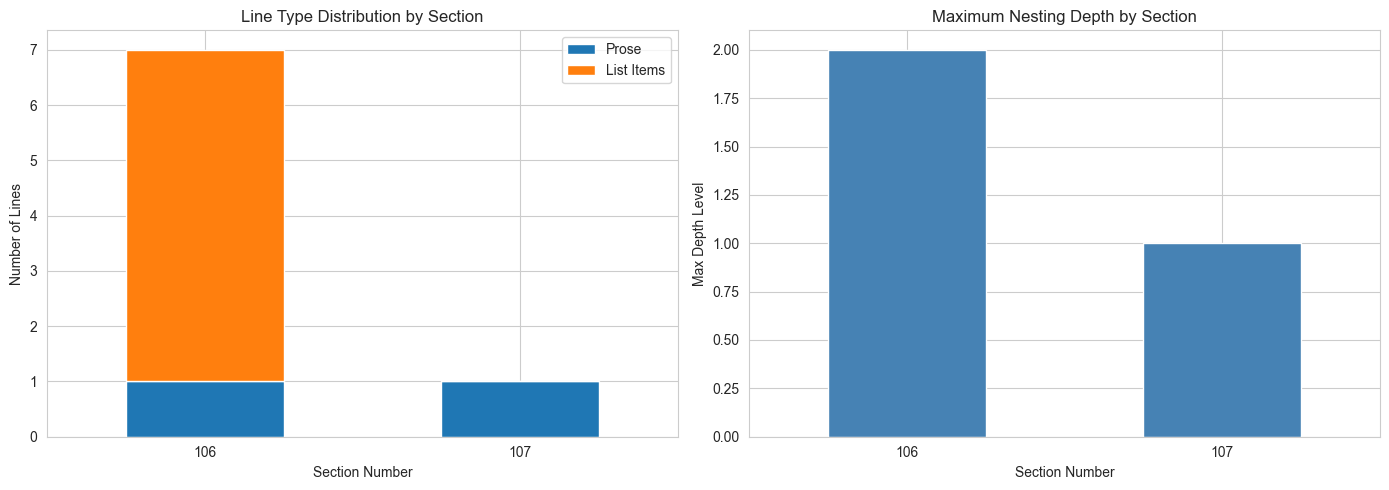

In [ ]:
# Analyze structure across all sections in our example
all_sections_stats = []

for section in root.findall('.//section'):
    lines = parse_section_lines(section)
    
    stats = {
        'section': section.get('number'),
        'total_lines': len(lines),
        'heading_lines': sum(1 for l in lines if l.line_type == 'Heading'),
        'prose_lines': sum(1 for l in lines if l.line_type == 'Prose'),
        'list_items': sum(1 for l in lines if l.line_type == 'ListItem'),
        'max_depth': max(l.depth_level for l in lines) if lines else 0
    }
    all_sections_stats.append(stats)

df_stats = pd.DataFrame(all_sections_stats)
print("Section Structure Statistics:")
print("="*60)
print(df_stats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Line type distribution
df_stats[['prose_lines', 'list_items']].plot(kind='bar', ax=axes[0], stacked=True)
axes[0].set_title('Line Type Distribution by Section')
axes[0].set_xlabel('Section Number')
axes[0].set_ylabel('Number of Lines')
axes[0].set_xticklabels(df_stats['section'], rotation=0)
axes[0].legend(['Prose', 'List Items'])

# Depth analysis
df_stats['max_depth'].plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Maximum Nesting Depth by Section')
axes[1].set_xlabel('Section Number')
axes[1].set_ylabel('Max Depth Level')
axes[1].set_xticklabels(df_stats['section'], rotation=0)

plt.tight_layout()
plt.show()

## 10. Working with Real OLRC XML Files

To work with actual OLRC XML files:

1. **Download XML files** from https://uscode.house.gov/download/download.shtml
2. **Extract the ZIP files** (organized by title)
3. **Use the parsing functions above** to analyze real data

### Example code for loading a real XML file:

In [ ]:
# Example: Load a real OLRC XML file (uncomment when you have actual files)
'''
from pathlib import Path

# Path to downloaded OLRC XML file
xml_file_path = Path('path/to/usc17.xml')  # Example: Title 17 XML file

if xml_file_path.exists():
    # Parse the XML file
    tree = etree.parse(str(xml_file_path))
    root = tree.getroot()
    
    # Extract all sections
    all_sections = root.findall('.//section')
    print(f"Found {len(all_sections)} sections in {xml_file_path.name}")
    
    # Parse and analyze
    for section in all_sections[:5]:  # First 5 sections as example
        lines = parse_section_lines(section)
        print(f"Section {section.get('number')}: {len(lines)} lines")
else:
    print(f"File not found: {xml_file_path}")
    print("Download XML files from OLRC first.")
'''

print("Code example ready - uncomment and modify paths to use with real files")

Code example ready - uncomment and modify paths to use with real files


## 11. Next Steps for CWLB Implementation

Based on this exploration, here are the key tasks for CWLB:

### Data Pipeline Tasks:
1. **Download and ingest** all OLRC XML files for selected titles (see TASKS.md Task 1.6)
2. **Parse sections** into USCodeLine records with tree structure (Task 1.13-1.14)
3. **Extract metadata** (section headings, subsection paths, depths)
4. **Build parent/child relationships** in database (Task 1.14)

### Parsing Challenges to Address:
- **Deeply nested sections** (e.g., § 512(c)(1)(A)(i)) require robust tree-building
- **Multiple XML formats** may exist across different OLRC releases
- **Cross-references** between sections need special handling
- **Tables and special formatting** in some sections

### Database Schema:
The USCodeLine table structure explored here maps directly to the data model in THE_CODE_WE_LIVE_BY_SPEC.md (Section 6).

### Blame Attribution:
After parsing sections into lines, the next step is matching each line to the Public Law that created or modified it (Task 1.15).

## 12. Quick Reference

### Key OLRC Resources:
- **Main site**: https://uscode.house.gov/
- **Download page**: https://uscode.house.gov/download/download.shtml
- **Classification tables**: https://uscode.house.gov/detailed_tables.xhtml

### XML Structure Elements:
- `<title>` - Title level (e.g., Title 17)
- `<chapter>` - Chapter within a title
- `<section>` - Individual section (fundamental unit)
- `<heading>` - Headings at any level
- `<content>` - Section content container
- `<para>` - Paragraph/prose text
- `<enum>` - Enumerated list container
- `<item>` - Individual list item
- `<text>` - Text content

### CWLB Line Types:
- **Heading** - Section titles, subsection headers
- **Prose** - Regular paragraph text
- **ListItem** - Enumerated items at any nesting level